In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xiaomengsun/car-insurance-claim-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\xiaomengsun\car-insurance-claim-data\versions\1


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, KFold, cross_validate
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import  SVR
from sklearn.tree import  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import pickle
import os

In [4]:
#Reading in the data 
raw_data = pd.read_csv('car_insurance_claim.csv')

In [5]:
pd.set_option('display.max_columns', None)
raw_data.head(20)

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban
5,743146596,0,17MAY49,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,$0,17.0,0,Highly Urban/ Urban
6,871024631,0,05MAY65,34.0,1,12.0,"$125,301",Yes,$0,z_No,z_F,Bachelors,z_Blue Collar,46,Commercial,"$17,430",1,Sports Car,no,$0,0,No,0,"$2,946",7.0,1,Highly Urban/ Urban
7,792300541,0,28FEB45,54.0,0,NaN,"$18,755",No,NaN,Yes,z_F,<High School,z_Blue Collar,33,Private,"$8,780",1,z_SUV,no,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
8,7945239,1,17SEP59,40.0,1,11.0,"$50,815",Yes,$0,z_No,M,z_High School,Manager,21,Private,"$18,930",6,Minivan,no,"$3,295",1,No,2,"$6,477",1.0,1,Highly Urban/ Urban
9,3577610,0,21AUG55,44.0,2,12.0,"$43,486",Yes,$0,z_No,z_F,z_High School,z_Blue Collar,30,Commercial,"$5,900",10,z_SUV,no,$0,0,No,0,$0,10.0,0,z_Highly Rural/ Rural


In [5]:
# Create new copy of data
data_df = raw_data.copy()

In [6]:
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'travel_time',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

In [7]:
# Update column names
data_df.rename(columns=col_names, inplace=True)

In [8]:
pd.set_option('display.max_columns', None)
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,travel_time,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  travel_time                10302 non-null  int

In [10]:
data_df.describe(include='all')

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,travel_time,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
count,1.030200e+04,10302.000000,10302,10295.000000,10302.000000,9754.000000,9732,10302,9727,10302,10302,10302,9637,10302.000000,10302,10302,10302.000000,10302,10302,10302,10302.000000,10302,10302.000000,10302,9663.000000,10302.000000,10302
unique,NaN,NaN,6560,NaN,NaN,NaN,8151,2,6334,2,2,5,8,NaN,2,2985,NaN,6,2,3545,NaN,2,NaN,2346,NaN,NaN,2
top,NaN,NaN,20OCT60,NaN,NaN,NaN,$0,No,$0,Yes,z_F,z_High School,z_Blue Collar,NaN,Private,"$1,500",NaN,z_SUV,no,$0,NaN,No,NaN,$0,NaN,NaN,Highly Urban/ Urban
freq,NaN,NaN,8,NaN,NaN,NaN,797,8959,2908,6188,5545,2952,2288,NaN,6513,207,NaN,2883,7326,6292,NaN,9041,NaN,7556,NaN,NaN,8230
mean,4.956631e+08,0.169288,NaN,44.837397,0.720443,10.474062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.416424,NaN,NaN,5.329159,NaN,NaN,NaN,0.800718,NaN,1.710153,NaN,8.298148,0.266550,NaN
std,2.864675e+08,0.506512,NaN,8.606445,1.116323,4.108943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.869687,NaN,NaN,4.110795,NaN,NaN,NaN,1.154079,NaN,2.159015,NaN,5.714450,0.442177,NaN
min,6.317500e+04,0.000000,NaN,16.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,-3.000000,0.000000,NaN
25%,2.442869e+08,0.000000,NaN,39.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,0.000000,NaN
50%,4.970043e+08,0.000000,NaN,45.000000,0.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,8.000000,0.000000,NaN
75%,7.394551e+08,0.000000,NaN,51.000000,1.000000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,NaN,NaN,7.000000,NaN,NaN,NaN,2.000000,NaN,3.000000,NaN,12.000000,1.000000,NaN


In [11]:
data_df.shape

(10302, 27)

In [12]:
data_df.columns

Index(['ID', 'num_young_drivers', 'date_of_birth', 'age', 'num_of_children',
       'years_job_held_for', 'income', 'single_parent', 'value_of_home',
       'married', 'gender', 'highest_education', 'occupation', 'travel_time',
       'type_of_use', 'vehicle_value', 'policy_tenure', 'vehicle_type',
       'red_vehicle', '5_year_total_claims_value', '5_year_num_of_claims',
       'licence_revoked', 'license_points', 'new_claim_value', 'vehicle_age',
       'is_claim', 'address_type'],
      dtype='object')

In [13]:
# Check number of duplicate records
data_df.duplicated().sum()

1

In [14]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [15]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('float64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

In [16]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

At this stage we can drop unuseful features:

ID is just a unique identifier so is not needed
data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [17]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [18]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,travel_time,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230.0,11,Minivan,yes,4461.0,2,No,3,0.0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940.0,1,Minivan,yes,0.0,0,No,0,0.0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970.0,1,Van,yes,0.0,0,No,2,0.0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010.0,4,SUV,no,38690.0,2,No,3,0.0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440.0,7,Minivan,yes,0.0,0,No,0,0.0,6.0,0,Highly Urban/ Urban


In [19]:
data_df.shape

(10301, 25)

In [20]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,travel_time,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


In [21]:
data_df.isna().sum()

num_young_drivers              0
age                            7
num_of_children                0
years_job_held_for           548
income                       570
single_parent                  0
value_of_home                575
married                        0
gender                         0
highest_education              0
occupation                   665
travel_time                    0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
red_vehicle                    0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
new_claim_value                0
vehicle_age                  639
is_claim                       0
address_type                   0
dtype: int64

In [22]:
(data_df.isna().sum()/len(data_df))*100

num_young_drivers            0.000000
age                          0.067955
num_of_children              0.000000
years_job_held_for           5.319872
income                       5.533443
single_parent                0.000000
value_of_home                5.581982
married                      0.000000
gender                       0.000000
highest_education            0.000000
occupation                   6.455684
travel_time                  0.000000
type_of_use                  0.000000
vehicle_value                0.000000
policy_tenure                0.000000
vehicle_type                 0.000000
red_vehicle                  0.000000
5_year_total_claims_value    0.000000
5_year_num_of_claims         0.000000
licence_revoked              0.000000
license_points               0.000000
new_claim_value              0.000000
vehicle_age                  6.203281
is_claim                     0.000000
address_type                 0.000000
dtype: float64

In [23]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = data_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = data_df.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [24]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(data_df, numerical_cols, knn_imputer)

In [25]:
num_test_data_imputed

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,travel_time,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim
0,0.0,60.0,0.0,11.0,67349.0,0.0,14.0,14230.0,11.0,4461.0,2.0,3.0,0.0,18.0,0.0
1,0.0,43.0,0.0,11.0,91449.0,257252.0,22.0,14940.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,48.0,0.0,11.0,52881.0,0.0,26.0,21970.0,1.0,0.0,0.0,2.0,0.0,10.0,0.0
3,0.0,35.0,1.0,10.0,16039.0,124191.0,5.0,4010.0,4.0,38690.0,2.0,3.0,0.0,10.0,0.0
4,0.0,51.0,0.0,14.0,38655.0,306251.0,32.0,15440.0,7.0,0.0,0.0,0.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296,1.0,45.0,2.0,9.0,164669.0,386273.0,21.0,13270.0,15.0,0.0,0.0,2.0,0.0,17.0,0.0
10297,0.0,46.0,0.0,9.0,107204.0,332591.0,36.0,24490.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0
10298,0.0,48.0,0.0,15.0,39837.0,170611.0,12.0,13820.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0
10299,0.0,50.0,0.0,7.0,43445.0,149248.0,36.0,22550.0,6.0,0.0,0.0,0.0,0.0,11.0,0.0


In [26]:
num_test_data_imputed.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
travel_time                  0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
new_claim_value              0
vehicle_age                  0
is_claim                     0
dtype: int64

In [27]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(data_df, cat_cols, simple_imputer)

In [28]:
cat_test_data_imputed.isnull().sum()

single_parent        0
married              0
gender               0
highest_education    0
occupation           0
type_of_use          0
vehicle_type         0
red_vehicle          0
licence_revoked      0
address_type         0
dtype: int64

In [29]:
imputed_df= pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,travel_time,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,red_vehicle,licence_revoked,address_type
0,0.0,60.0,0.0,11.0,67349.0,0.0,14.0,14230.0,11.0,4461.0,2.0,3.0,0.0,18.0,0.0,No,No,M,PhD,Professional,Private,Minivan,yes,No,Highly Urban/ Urban
1,0.0,43.0,0.0,11.0,91449.0,257252.0,22.0,14940.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,No,No,M,High School,Blue Collar,Commercial,Minivan,yes,No,Highly Urban/ Urban
2,0.0,48.0,0.0,11.0,52881.0,0.0,26.0,21970.0,1.0,0.0,0.0,2.0,0.0,10.0,0.0,No,No,M,Bachelors,Manager,Private,Van,yes,No,Highly Urban/ Urban
3,0.0,35.0,1.0,10.0,16039.0,124191.0,5.0,4010.0,4.0,38690.0,2.0,3.0,0.0,10.0,0.0,No,Yes,F,High School,Clerical,Private,SUV,no,No,Highly Urban/ Urban
4,0.0,51.0,0.0,14.0,38655.0,306251.0,32.0,15440.0,7.0,0.0,0.0,0.0,0.0,6.0,0.0,No,Yes,M,<High School,Blue Collar,Private,Minivan,yes,No,Highly Urban/ Urban


In [30]:
imputed_df.shape

(10301, 25)

<Axes: xlabel='new_claim_value', ylabel='Count'>

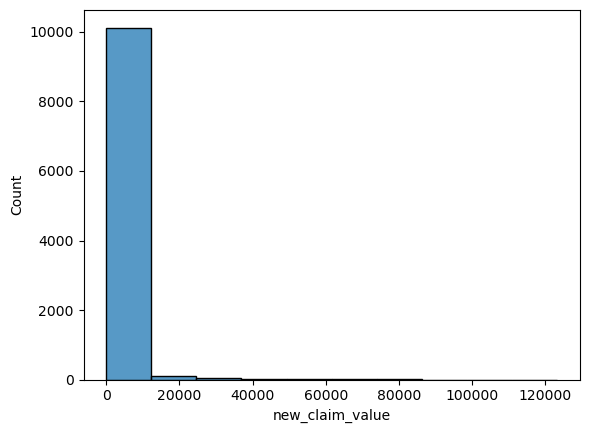

In [31]:
#univariant analysis
# Create hisogram for new claim value
sns.histplot(imputed_df['new_claim_value'], bins=10)

We can see the feature is heavily skewed right. It would likely be best to use non-linearly spaced bins to capture the more extreme values with few instances.

In [32]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
imputed_df['new_claim_value1'] = pd.cut(imputed_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='new_claim_value1'>

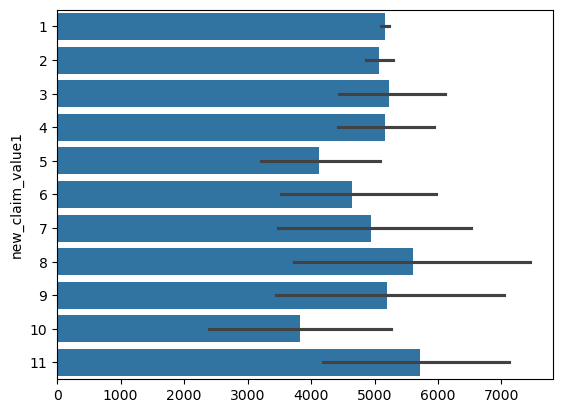

In [33]:
sns.barplot(imputed_df['new_claim_value1'])

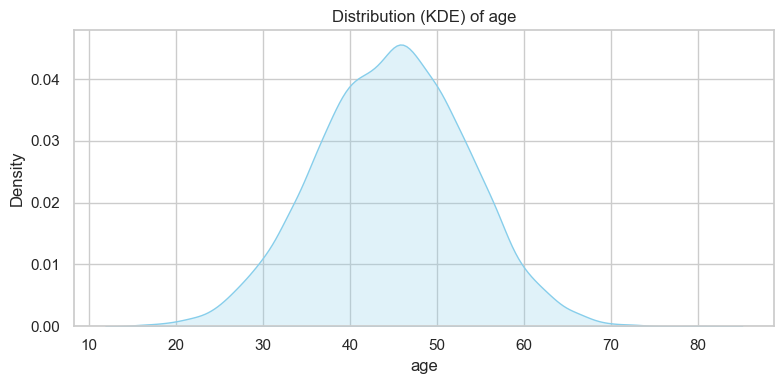

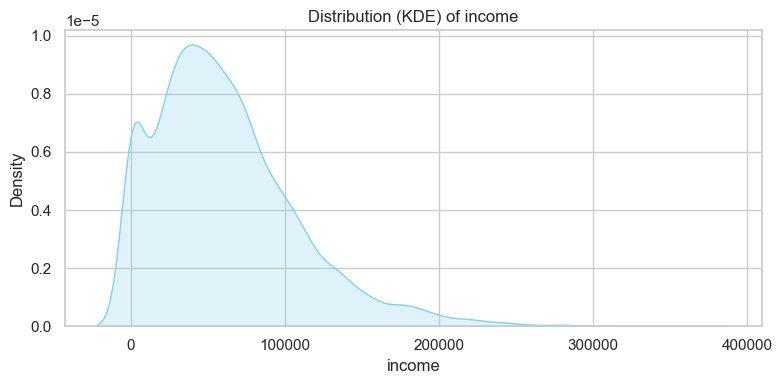

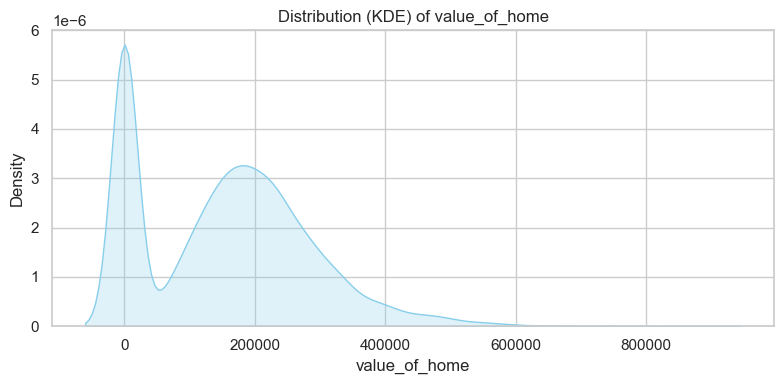

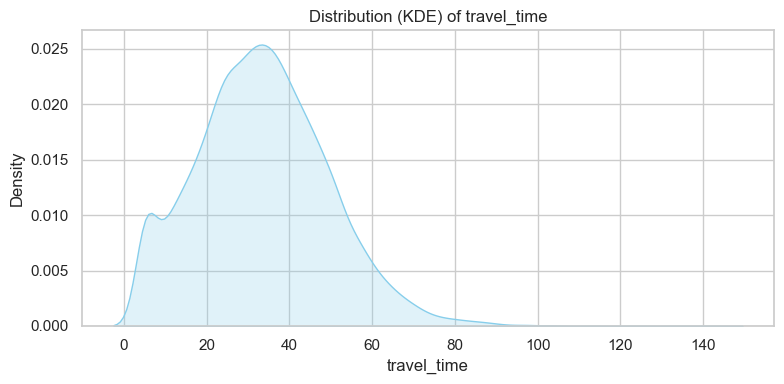

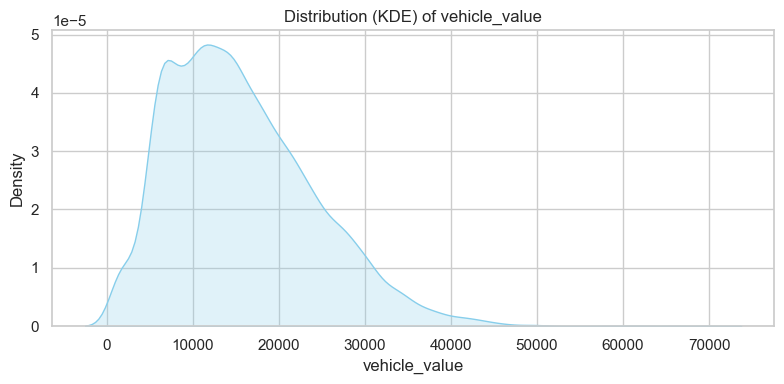

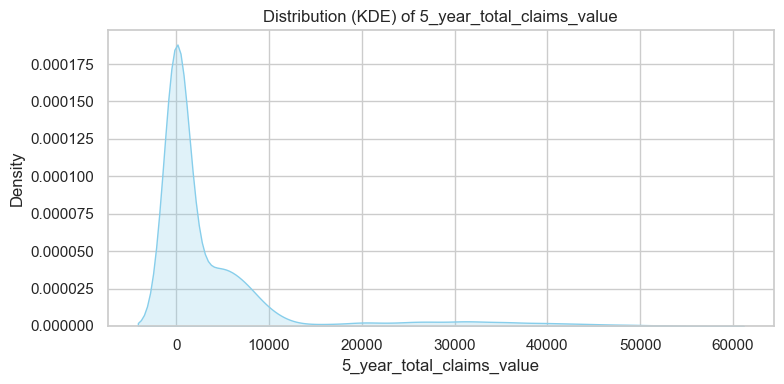

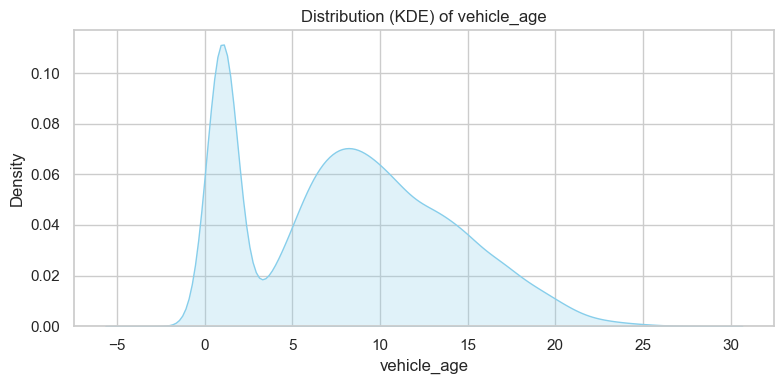

In [34]:
sns.set_theme(style="whitegrid")
numeric_cols = ['age', 'income', 'value_of_home', 'travel_time','vehicle_value','5_year_total_claims_value','vehicle_age']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=imputed_df, x=col, fill=True, color='skyblue')
    plt.title(f'Distribution (KDE) of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


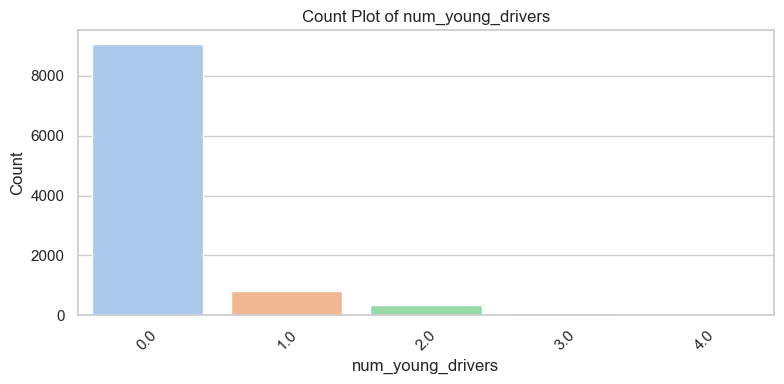

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


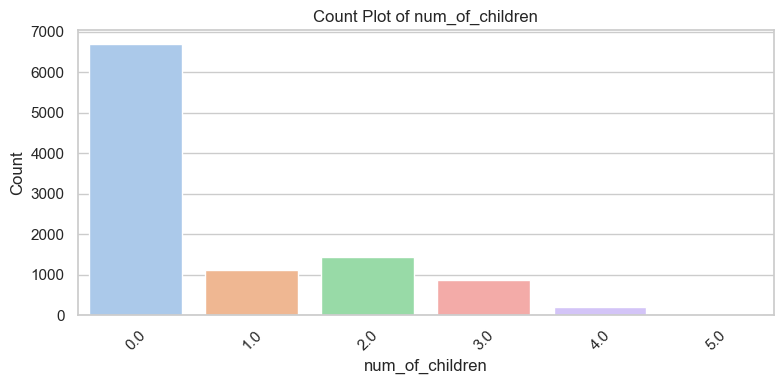

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


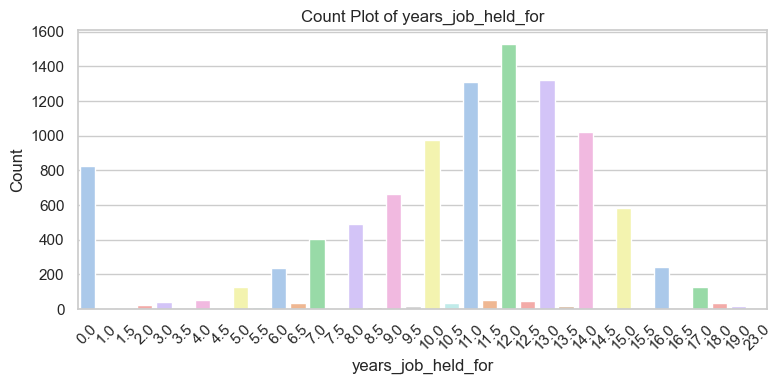

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


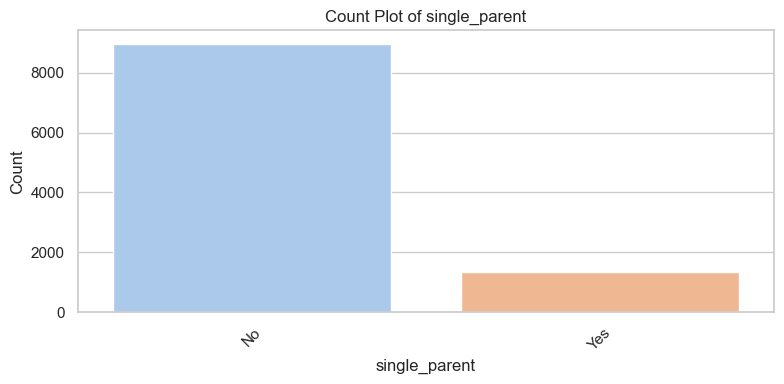

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


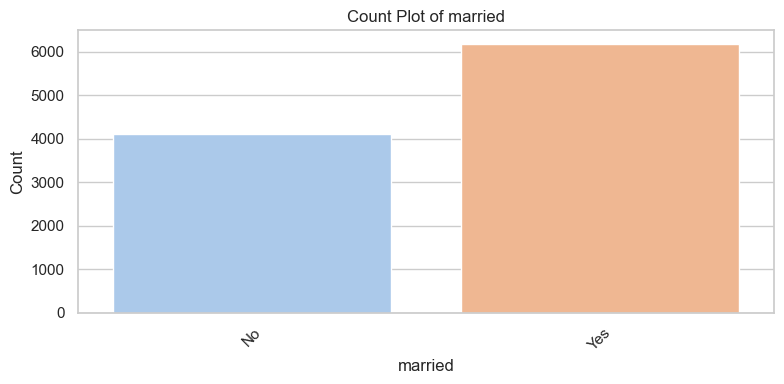

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


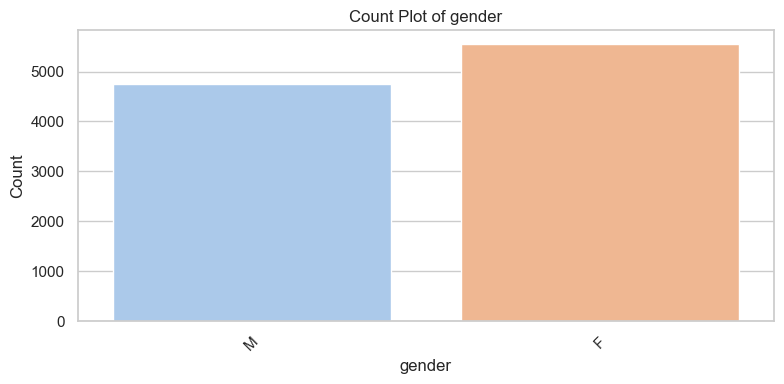

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


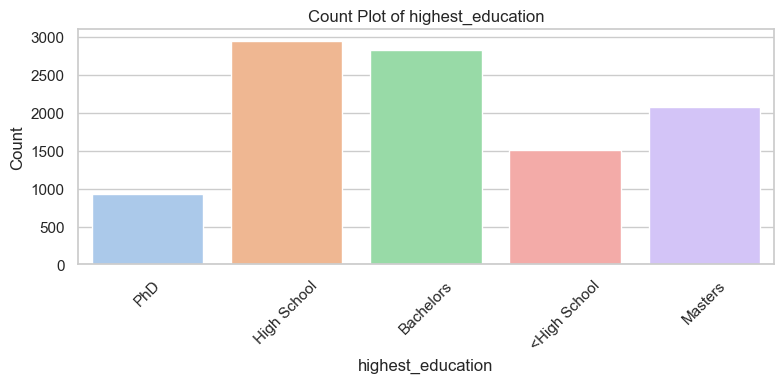

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


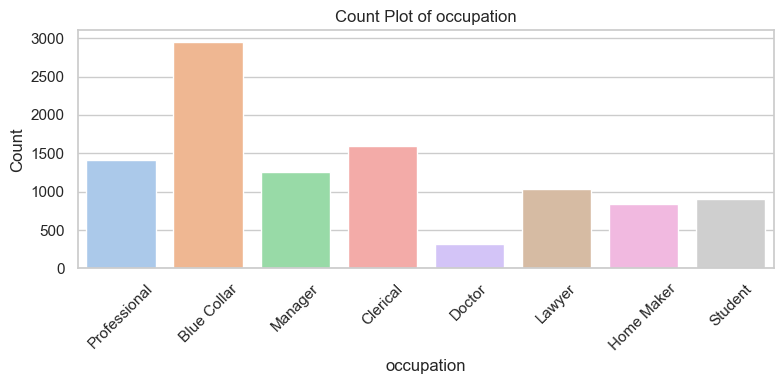

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


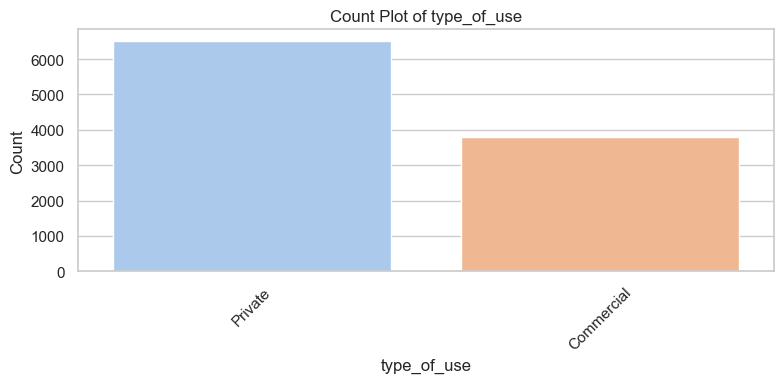

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


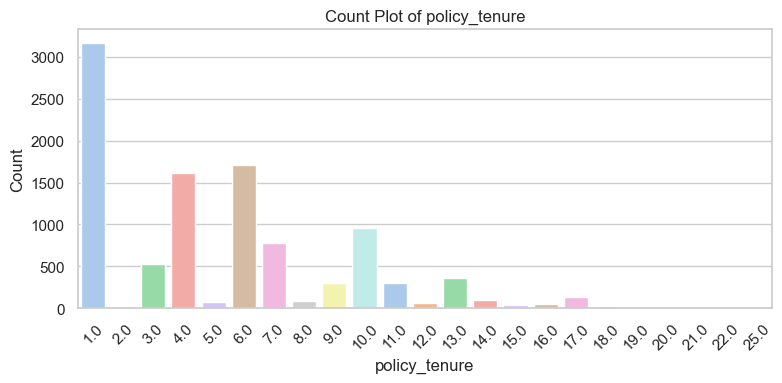

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


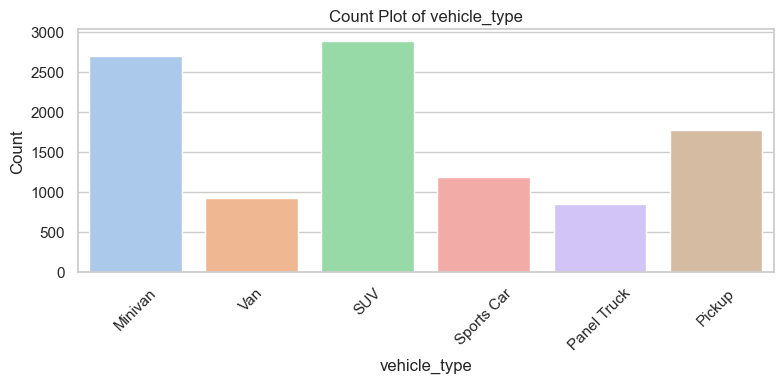

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


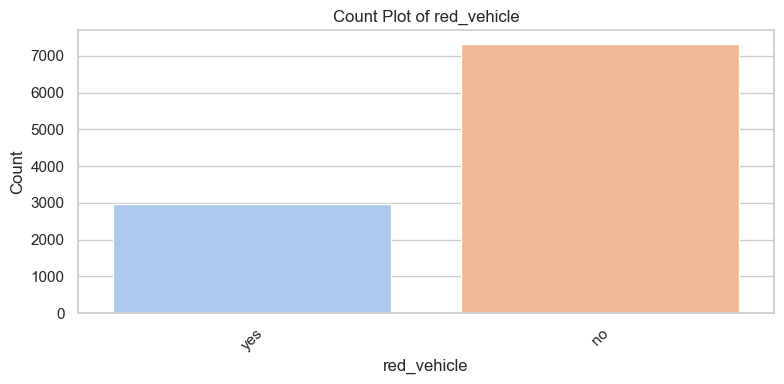

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


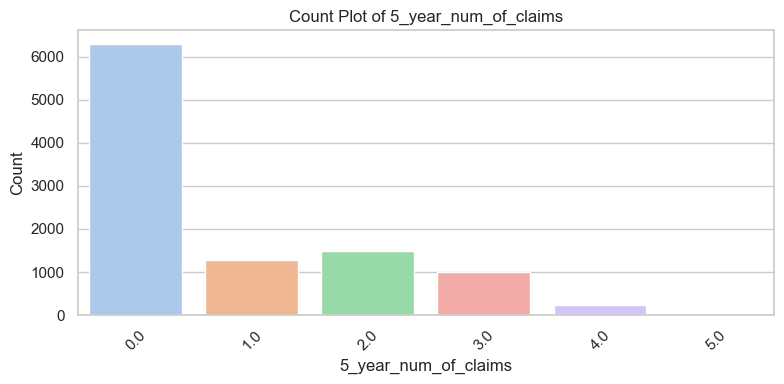

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


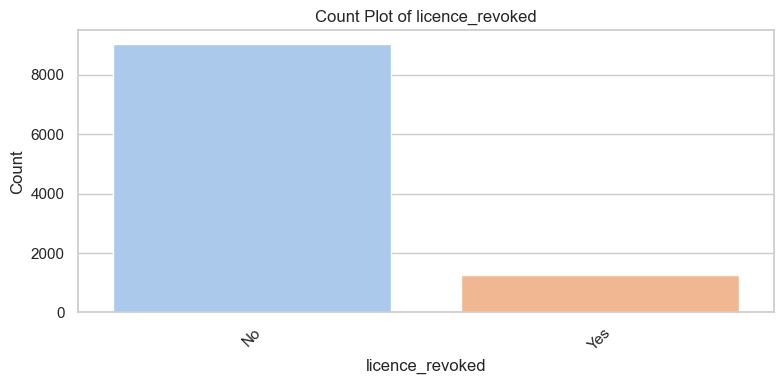

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


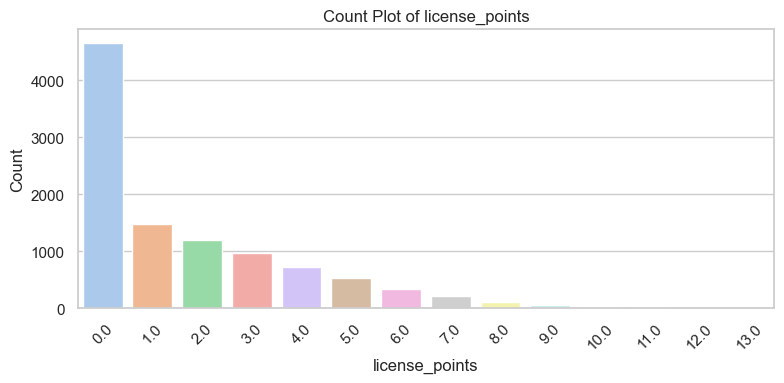

C:\Users\DELL\AppData\Local\Temp\ipykernel_26752\556915256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=imputed_df, x=col, palette="pastel")


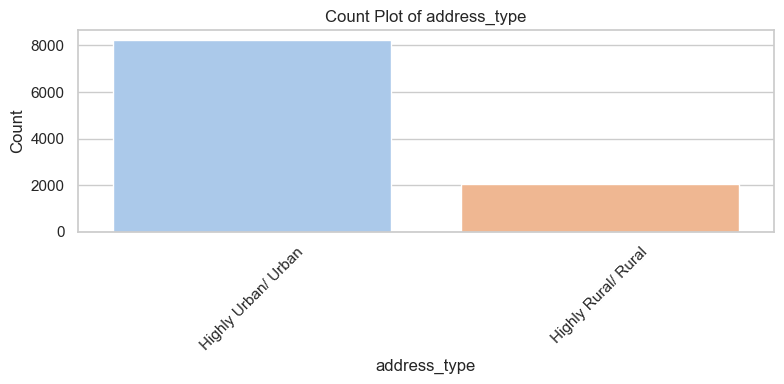

In [37]:
categorical_cols=['num_young_drivers','num_of_children','years_job_held_for','single_parent','married', 'gender', 
                  'highest_education', 'occupation','type_of_use', 'policy_tenure', 'vehicle_type',
                  'red_vehicle','5_year_num_of_claims','licence_revoked', 'license_points', 'address_type']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=imputed_df, x=col, palette="pastel")
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [36]:
numeric_cols = ['age', 'income', 'value_of_home', 'travel_time','vehicle_value','5_year_total_claims_value','vehicle_age']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=df, x=col, y='new_claim_value',scatter=False,color='red')
    plt.title(f'Scatter Plot: {col} vs new_claim_value')
    plt.tight_layout()
    plt.show()

NameError: name 'df' is not defined

<Figure size 600x400 with 0 Axes>

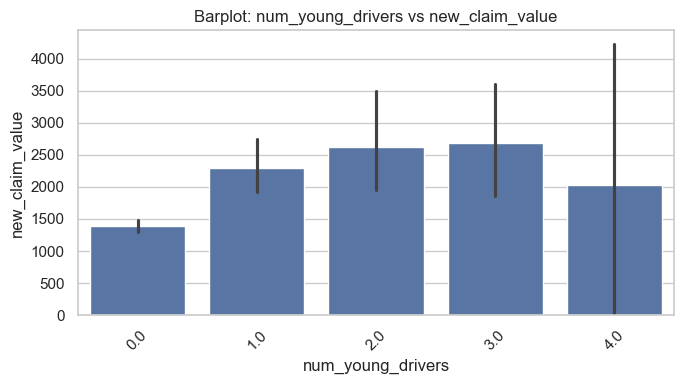

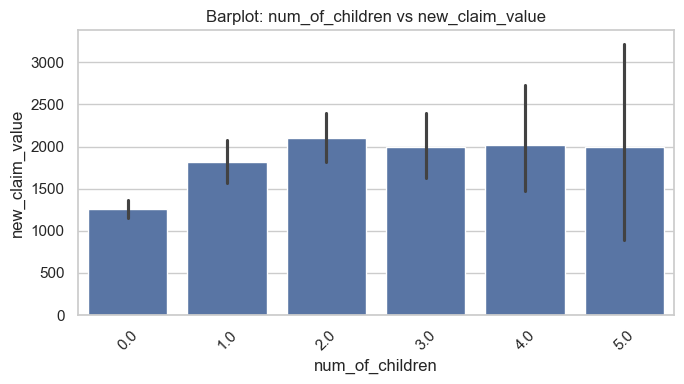

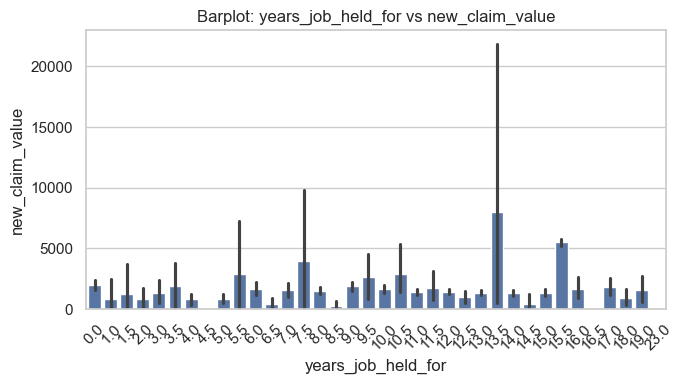

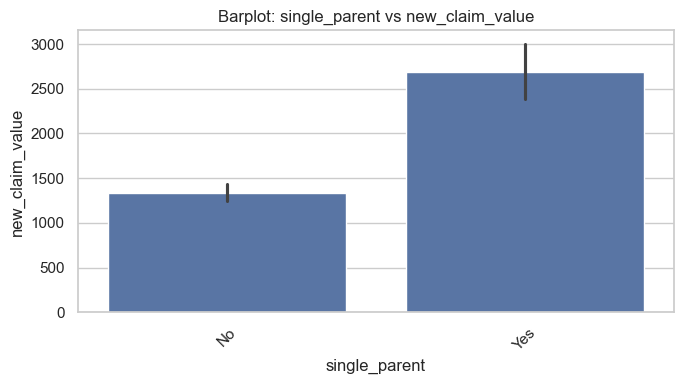

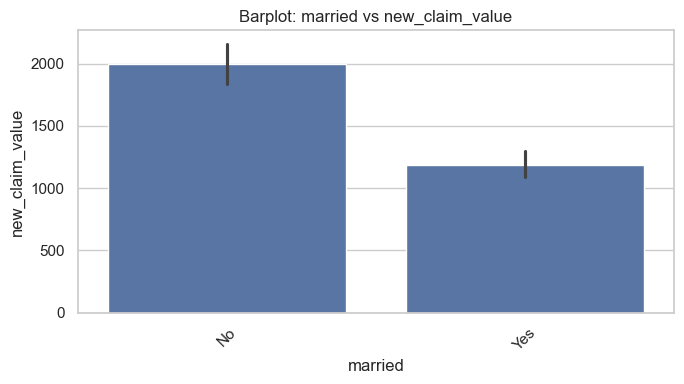

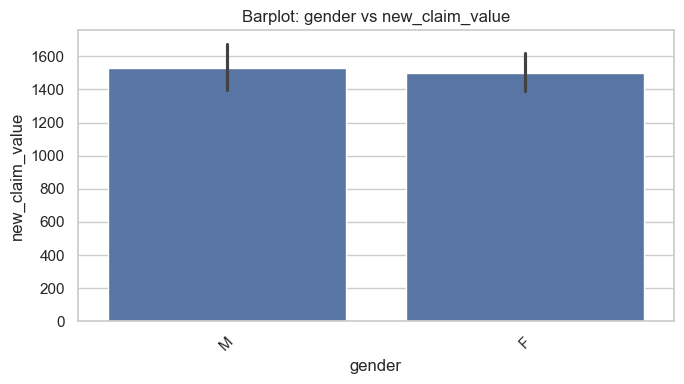

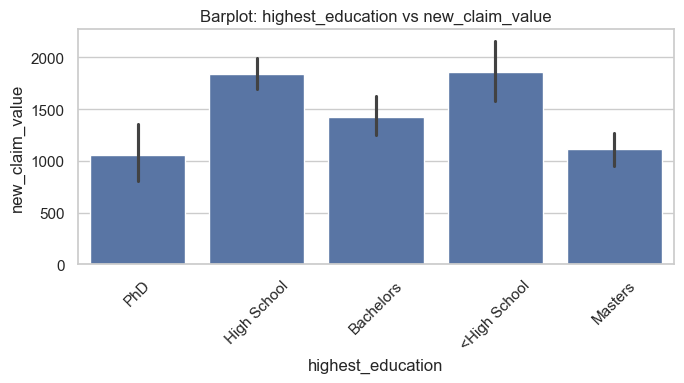

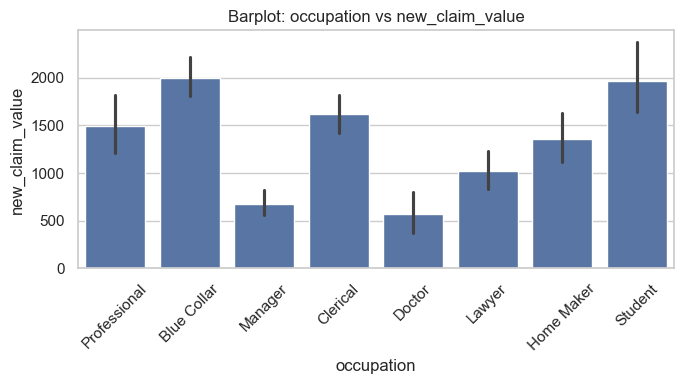

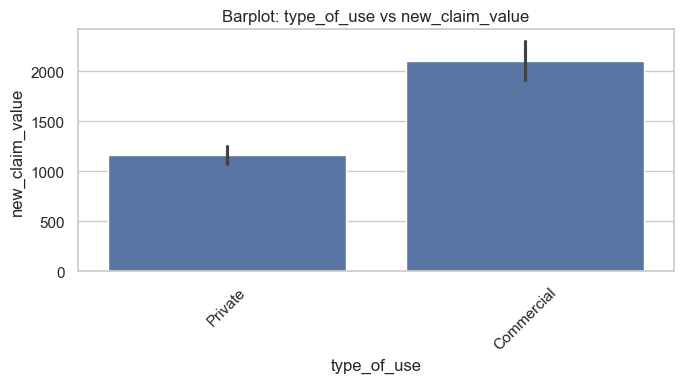

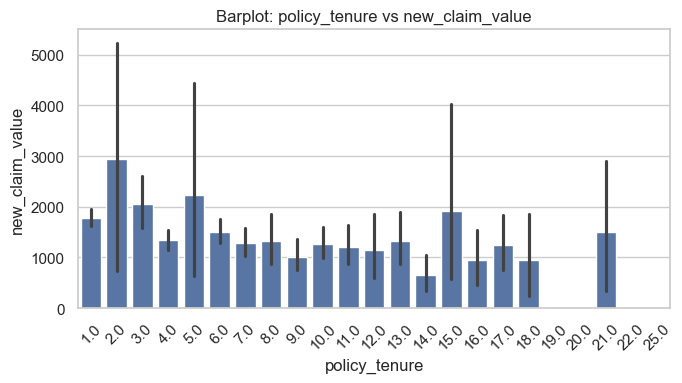

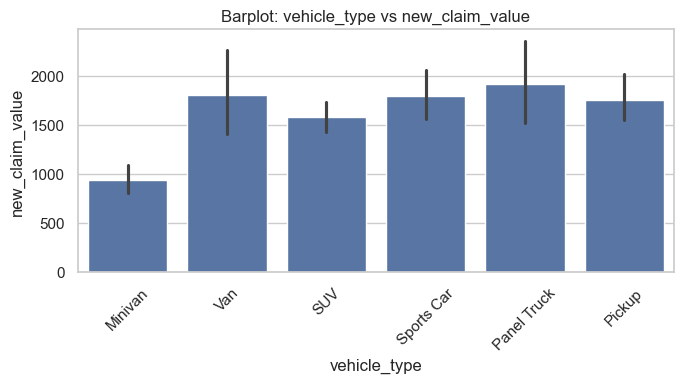

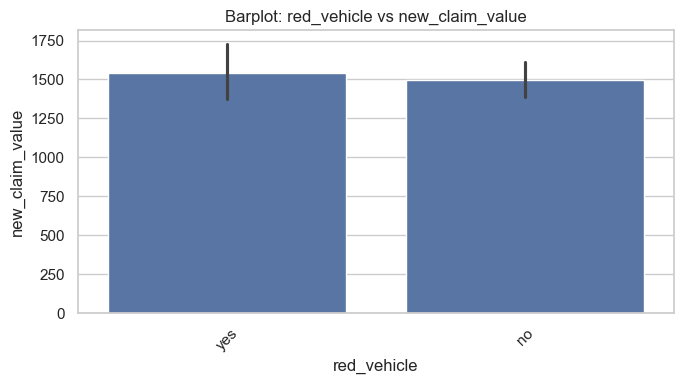

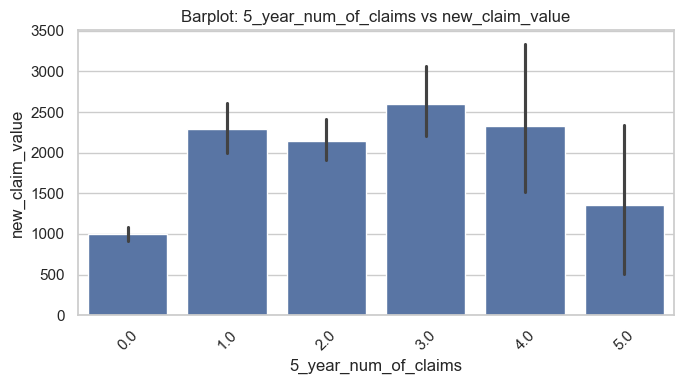

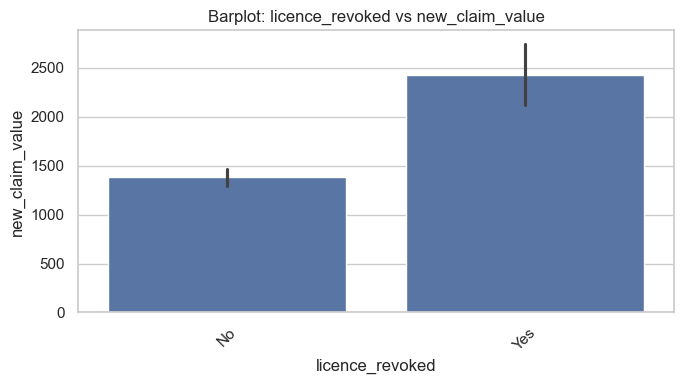

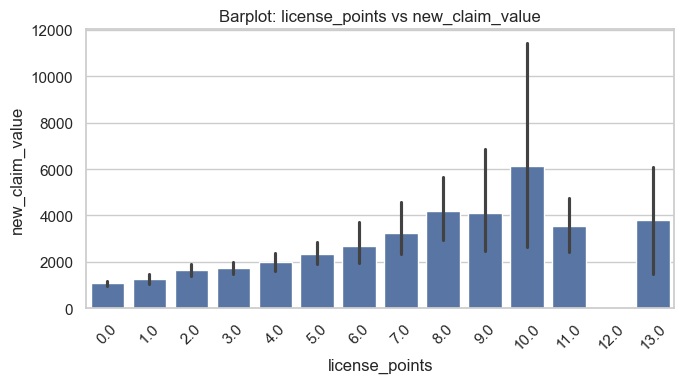

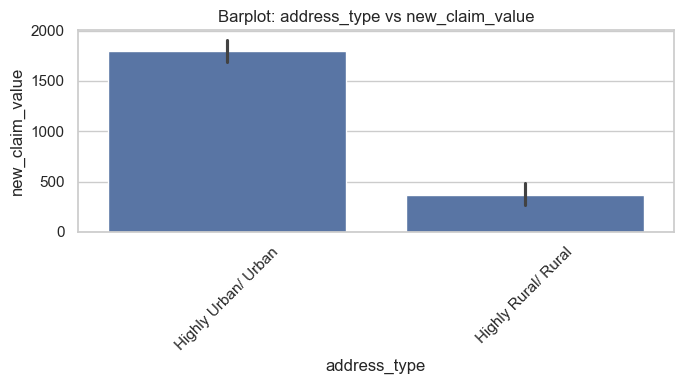

In [38]:
# 2. Categorical vs Target (boxplots)
categorical_cols=['num_young_drivers','num_of_children','years_job_held_for','single_parent','married', 'gender', 
                  'highest_education', 'occupation','type_of_use', 'policy_tenure', 'vehicle_type',
                  'red_vehicle','5_year_num_of_claims','licence_revoked', 'license_points', 'address_type']
for col in categorical_cols:
    plt.figure(figsize=(7, 4))
    sns.barplot(data=imputed_df, x=col, y='new_claim_value')
    plt.title(f'Barplot: {col} vs new_claim_value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


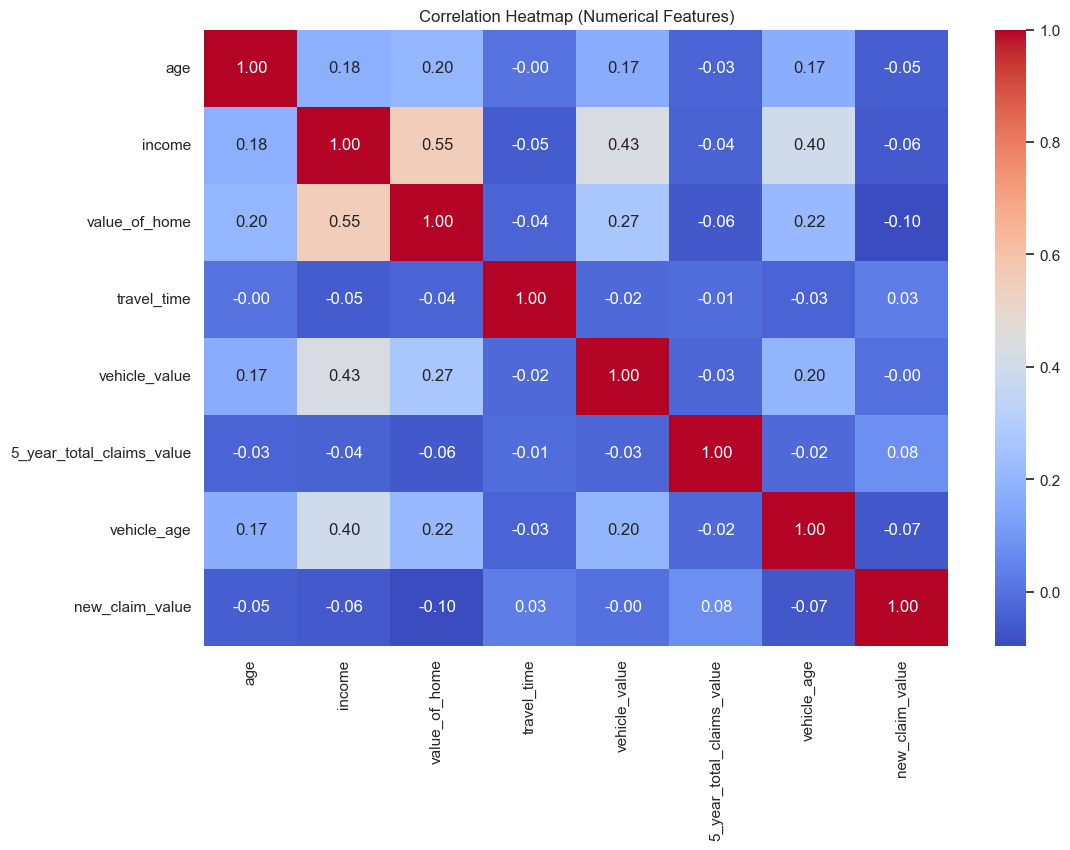

In [39]:
# Compute correlation only for numerical columns
corr_matrix = imputed_df[numeric_cols + ['new_claim_value']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

In [40]:
insurance_df=imputed_df[imputed_df['is_claim'] == 1]

In [41]:
insurance_df.shape

(2746, 26)

In [42]:
insurance_df

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,travel_time,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,red_vehicle,licence_revoked,address_type,new_claim_value1
6,0.0,34.0,1.0,12.0,125301.0,0.0,46.0,17430.0,1.0,0.0,0.0,0.0,2946.0,7.0,1.0,Yes,No,F,Bachelors,Blue Collar,Commercial,Sports Car,no,No,Highly Urban/ Urban,1
8,1.0,40.0,1.0,11.0,50815.0,0.0,21.0,18930.0,6.0,3295.0,1.0,2.0,6477.0,1.0,1.0,Yes,No,M,High School,Manager,Private,Minivan,no,No,Highly Urban/ Urban,2
10,1.0,37.0,2.0,13.0,107961.0,333680.0,44.0,16970.0,1.0,2374.0,1.0,10.0,4021.0,7.0,1.0,No,Yes,M,Bachelors,Blue Collar,Commercial,Van,yes,Yes,Highly Urban/ Urban,1
11,0.0,34.0,0.0,10.0,62978.0,0.0,34.0,11200.0,1.0,0.0,0.0,0.0,2501.0,1.0,1.0,No,No,F,Bachelors,Clerical,Private,SUV,no,No,Highly Urban/ Urban,1
13,0.0,53.0,0.0,14.0,77100.0,0.0,15.0,18300.0,1.0,0.0,0.0,0.0,6077.0,11.0,1.0,No,No,F,Masters,Lawyer,Private,Sports Car,no,No,Highly Urban/ Urban,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263,0.0,43.0,0.0,0.0,0.0,55203.0,29.0,24030.0,9.0,3035.0,4.0,0.0,471.0,14.0,1.0,No,Yes,F,PhD,Home Maker,Private,Minivan,no,No,Highly Urban/ Urban,1
10268,0.0,46.0,0.0,10.0,68360.0,237457.0,49.0,12940.0,1.0,6560.0,3.0,7.0,3135.0,11.0,1.0,No,No,M,Bachelors,Blue Collar,Commercial,Minivan,no,No,Highly Urban/ Urban,1
10284,0.0,41.0,0.0,12.0,92185.0,289370.0,24.0,1500.0,11.0,0.0,0.0,0.0,1815.0,10.0,1.0,No,Yes,M,High School,Professional,Private,Minivan,yes,No,Highly Urban/ Urban,1
10286,0.0,45.0,0.0,11.0,52966.0,0.0,16.0,11300.0,6.0,16239.0,2.0,5.0,2967.0,1.0,1.0,No,No,M,High School,Professional,Commercial,Pickup,yes,Yes,Highly Urban/ Urban,1


In [43]:
def IQR(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)

  IQR = Q3 - Q1
  LR = Q1 - (IQR * 1.5)
  UR = Q3 + (IQR * 1.5)

  return LR, UR

In [44]:
LR1, UR1 = IQR(insurance_df.income)
insurance_df= insurance_df[(insurance_df['income'] > LR1) & (insurance_df['income'] < UR1)]

In [45]:
LR1, UR1 = IQR(insurance_df.value_of_home)
insurance_df= insurance_df[(insurance_df['value_of_home'] > LR1) & (insurance_df['value_of_home'] < UR1)]

In [46]:
LR1, UR1 = IQR(insurance_df.vehicle_value)
insurance_df= insurance_df[(insurance_df['vehicle_value'] > LR1) & (insurance_df['vehicle_value'] < UR1)]

In [47]:
LR1, UR1 = IQR(insurance_df["5_year_total_claims_value"])
insurance_df= insurance_df[(insurance_df['5_year_total_claims_value'] > LR1) & (insurance_df['5_year_total_claims_value'] < UR1)]

In [48]:
LR1, UR1 = IQR(insurance_df.new_claim_value)
insurance_df= insurance_df[(insurance_df['new_claim_value'] > LR1) & (insurance_df['new_claim_value'] < UR1)]

<Axes: ylabel='new_claim_value'>

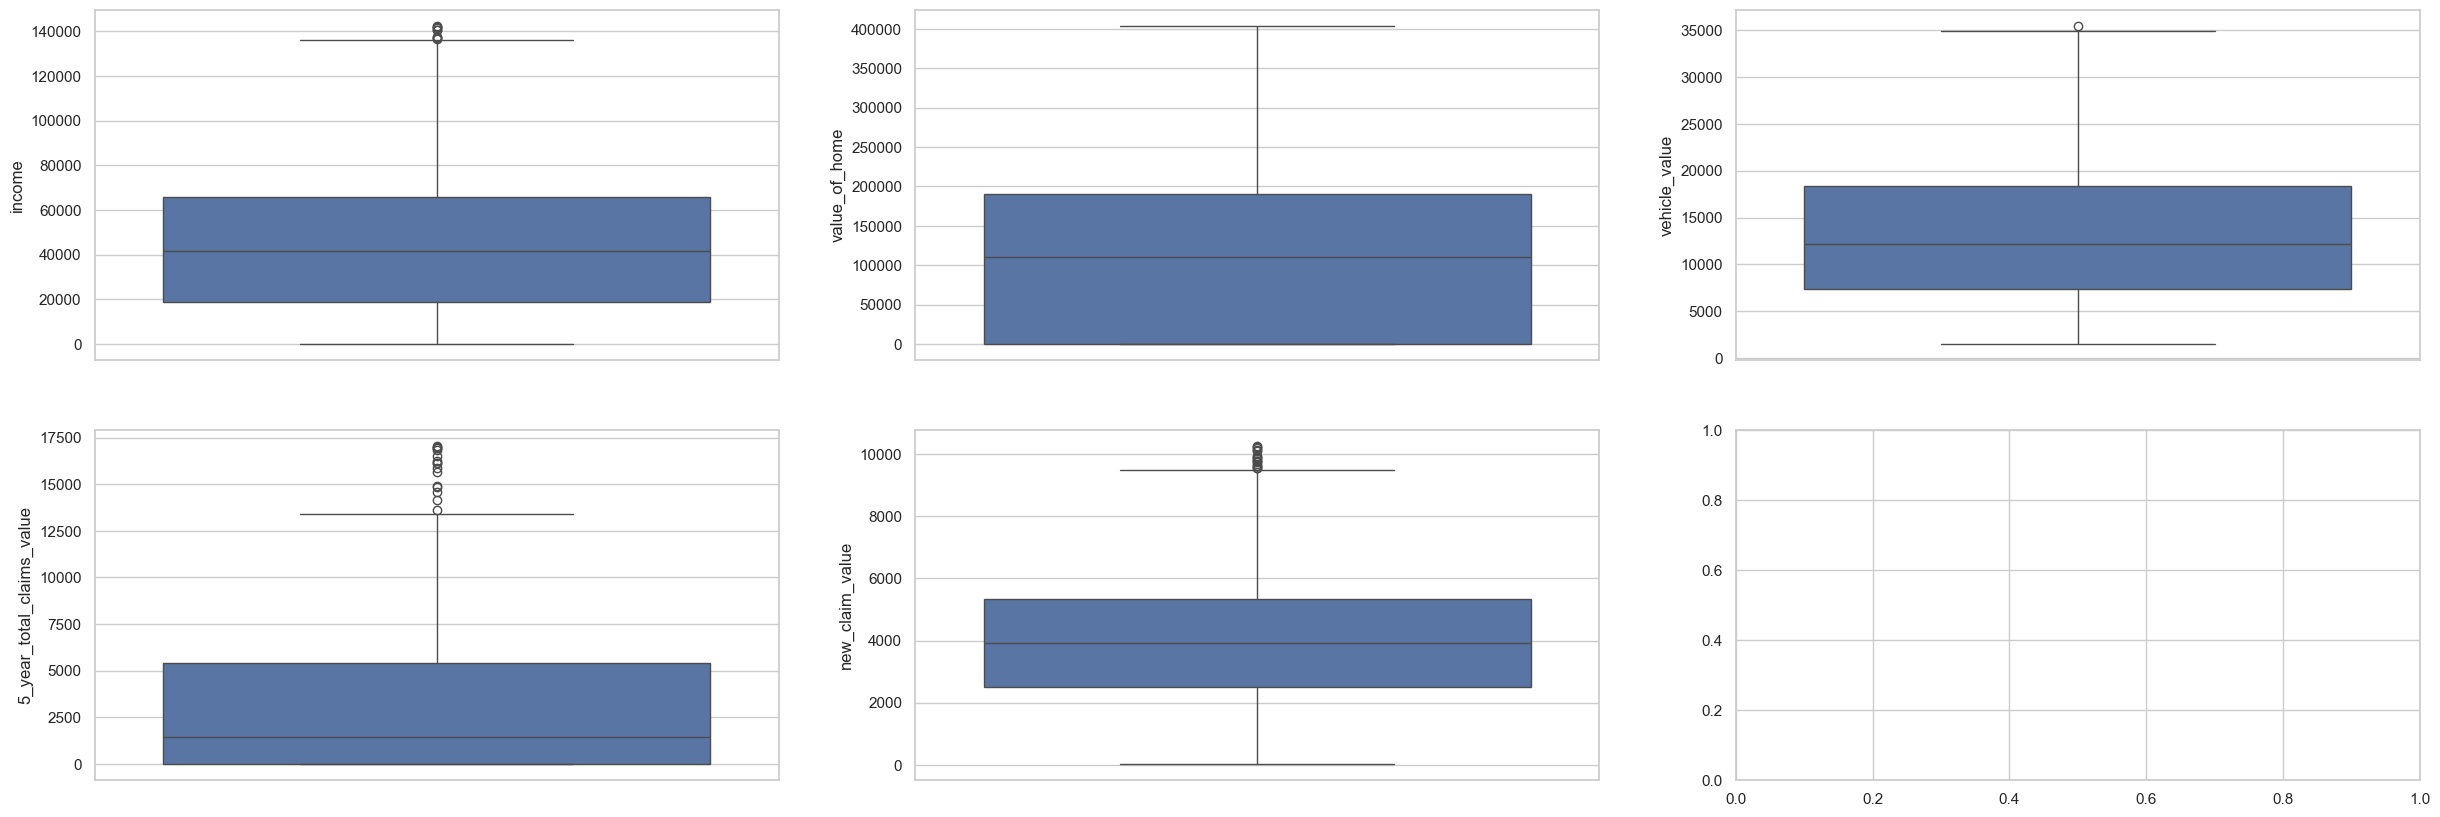

In [49]:
figure, axis = plt.subplots(2,3, figsize = (30,10))
sns.boxplot(y = 'income', data = insurance_df, ax = axis[0,0])
sns.boxplot(y = 'value_of_home',data = insurance_df, ax = axis[0,1])
sns.boxplot(y = 'vehicle_value', data = insurance_df, ax = axis[0,2])
sns.boxplot(y = '5_year_total_claims_value',data = insurance_df, ax = axis[1,0])
sns.boxplot(y = 'new_claim_value', data = insurance_df, ax = axis[1,1])

In [50]:
LR1, UR1 = IQR(insurance_df["5_year_total_claims_value"])
insurance_df= insurance_df[(insurance_df['5_year_total_claims_value'] > LR1) & 
                           (insurance_df['5_year_total_claims_value'] < UR1)]

<Axes: ylabel='5_year_total_claims_value'>

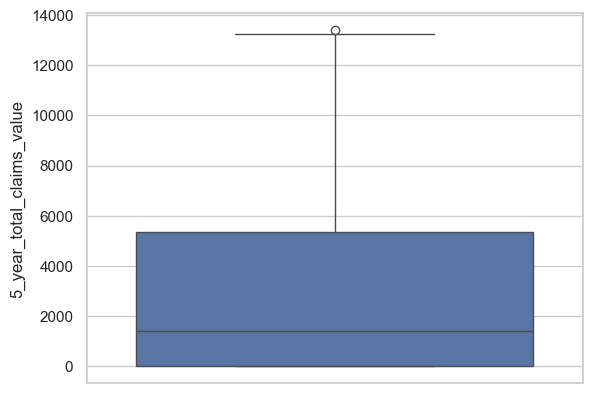

In [51]:

sns.boxplot(y = '5_year_total_claims_value',data = insurance_df)


In [52]:
insurance_df.shape

(2162, 26)

In [53]:
insurance_df

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,travel_time,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,red_vehicle,licence_revoked,address_type,new_claim_value1
6,0.0,34.0,1.0,12.0,125301.0,0.0,46.0,17430.0,1.0,0.0,0.0,0.0,2946.0,7.0,1.0,Yes,No,F,Bachelors,Blue Collar,Commercial,Sports Car,no,No,Highly Urban/ Urban,1
8,1.0,40.0,1.0,11.0,50815.0,0.0,21.0,18930.0,6.0,3295.0,1.0,2.0,6477.0,1.0,1.0,Yes,No,M,High School,Manager,Private,Minivan,no,No,Highly Urban/ Urban,2
10,1.0,37.0,2.0,13.0,107961.0,333680.0,44.0,16970.0,1.0,2374.0,1.0,10.0,4021.0,7.0,1.0,No,Yes,M,Bachelors,Blue Collar,Commercial,Van,yes,Yes,Highly Urban/ Urban,1
11,0.0,34.0,0.0,10.0,62978.0,0.0,34.0,11200.0,1.0,0.0,0.0,0.0,2501.0,1.0,1.0,No,No,F,Bachelors,Clerical,Private,SUV,no,No,Highly Urban/ Urban,1
13,0.0,53.0,0.0,14.0,77100.0,0.0,15.0,18300.0,1.0,0.0,0.0,0.0,6077.0,11.0,1.0,No,No,F,Masters,Lawyer,Private,Sports Car,no,No,Highly Urban/ Urban,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10257,2.0,46.0,0.0,11.0,35362.0,0.0,42.0,17970.0,11.0,5423.0,2.0,3.0,2318.0,7.0,1.0,No,No,M,High School,Clerical,Commercial,Pickup,no,Yes,Highly Urban/ Urban,1
10263,0.0,43.0,0.0,0.0,0.0,55203.0,29.0,24030.0,9.0,3035.0,4.0,0.0,471.0,14.0,1.0,No,Yes,F,PhD,Home Maker,Private,Minivan,no,No,Highly Urban/ Urban,1
10268,0.0,46.0,0.0,10.0,68360.0,237457.0,49.0,12940.0,1.0,6560.0,3.0,7.0,3135.0,11.0,1.0,No,No,M,Bachelors,Blue Collar,Commercial,Minivan,no,No,Highly Urban/ Urban,1
10284,0.0,41.0,0.0,12.0,92185.0,289370.0,24.0,1500.0,11.0,0.0,0.0,0.0,1815.0,10.0,1.0,No,Yes,M,High School,Professional,Private,Minivan,yes,No,Highly Urban/ Urban,1


In [54]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
red_vehicle          2
licence_revoked      2
address_type         2
dtype: int64

Single parent has only 2 values, so we can use binary encoding for this feature.
Married has only 2 values, so we can use binary encoding for this feature.
Gender has only 2 values, so we can use binary encoding for this feature.
Highest education has 5 unique values, and these have a rank/order (the level of education). We can use ordinal encoding for this feature.
For occupation, we have 8 differnet values with no ranking or order. We can use one-hot encoding for this feature.
Type of use has only 2 values, so we can use binary encoding for this feature.
Vehicle type has 6 different values with no ranking or order. We can use one-hot encoding for this feature.
Red vehicle has only 2 values, so we can use binary encoding for this feature.
License revoked has only 2 values, so we can use binary encoding for this feature.
Address type has only 2 values, so again, we can use binary encoding for this feature.
Since Scikit-Learn has no binary encoding option currently for independent features, we can use the ordinal encoder in this as we only have 2 unique values. We can now define which features will use which encoders:

In [55]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [56]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [57]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(insurance_df[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(insurance_df[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(insurance_df[cat_cols_one_hot])

In [58]:
# Prepare base DataFrame from numerical columns
numerical_cols = ['age', 'income', 'value_of_home', 'travel_time', 'vehicle_age', 
                  '5_year_num_of_claims', 'num_young_drivers']
cleandata = insurance_df[numerical_cols].copy()

In [59]:
cleandata

,age,income,value_of_home,travel_time,vehicle_age,5_year_num_of_claims,num_young_drivers
6,34.0,125301.0,0.0,46.0,7.0,0.0,0.0
8,40.0,50815.0,0.0,21.0,1.0,1.0,1.0
10,37.0,107961.0,333680.0,44.0,7.0,1.0,1.0
11,34.0,62978.0,0.0,34.0,1.0,0.0,0.0
13,53.0,77100.0,0.0,15.0,11.0,0.0,0.0
...,...,...,...,...,...,...,...
10257,46.0,35362.0,0.0,42.0,7.0,2.0,2.0
10263,43.0,0.0,55203.0,29.0,14.0,4.0,0.0
10268,46.0,68360.0,237457.0,49.0,11.0,3.0,0.0
10284,41.0,92185.0,289370.0,24.0,10.0,0.0,0.0


In [60]:
# Add encoded categorical features directly
cleandata[cat_cols_ord] = ord_encoded
cleandata[cat_cols_bin] = bin_encoded
one_hot_col_names = one_hot_encoder.get_feature_names_out()
for i, col in enumerate(one_hot_col_names):
    cleandata[col] = one_hot_encoded[:, i]

In [61]:
# Final check
print(cleandata.shape)  # Should be (2162, 28)
cleandata.head()

(2162, 28)


,age,income,value_of_home,travel_time,vehicle_age,5_year_num_of_claims,num_young_drivers,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
6,34.0,125301.0,0.0,46.0,7.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,40.0,50815.0,0.0,21.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,37.0,107961.0,333680.0,44.0,7.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,34.0,62978.0,0.0,34.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,53.0,77100.0,0.0,15.0,11.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [62]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(cleandata)
vif_df

D:\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,age,1.250418
2,income,2.624566
3,value_of_home,1.935400
4,travel_time,1.026397
5,vehicle_age,1.813401
6,5_year_num_of_claims,1.070192
7,num_young_drivers,1.133710
8,highest_education,2.593054
9,single_parent,1.724663


We can clearly see the features that were one-hot encoded (occupation and vehicle type) show perfect multicolinearity. The easiest way to deal with this is to drop one of the dummy variables from the encoded data. This is often referred to as dropping the 'reference category' or 'baseline' category.

In [63]:
cleandata.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [64]:
# Calculate VIF for encoded data
vif_df = calculate_vif(cleandata)
vif_df

,Feature,VIF
0,const,72.963910
1,age,1.250418
2,income,2.624566
3,value_of_home,1.935400
4,travel_time,1.026397
5,vehicle_age,1.813401
6,5_year_num_of_claims,1.070192
7,num_young_drivers,1.133710
8,highest_education,2.593054
9,single_parent,1.724663


<Axes: >

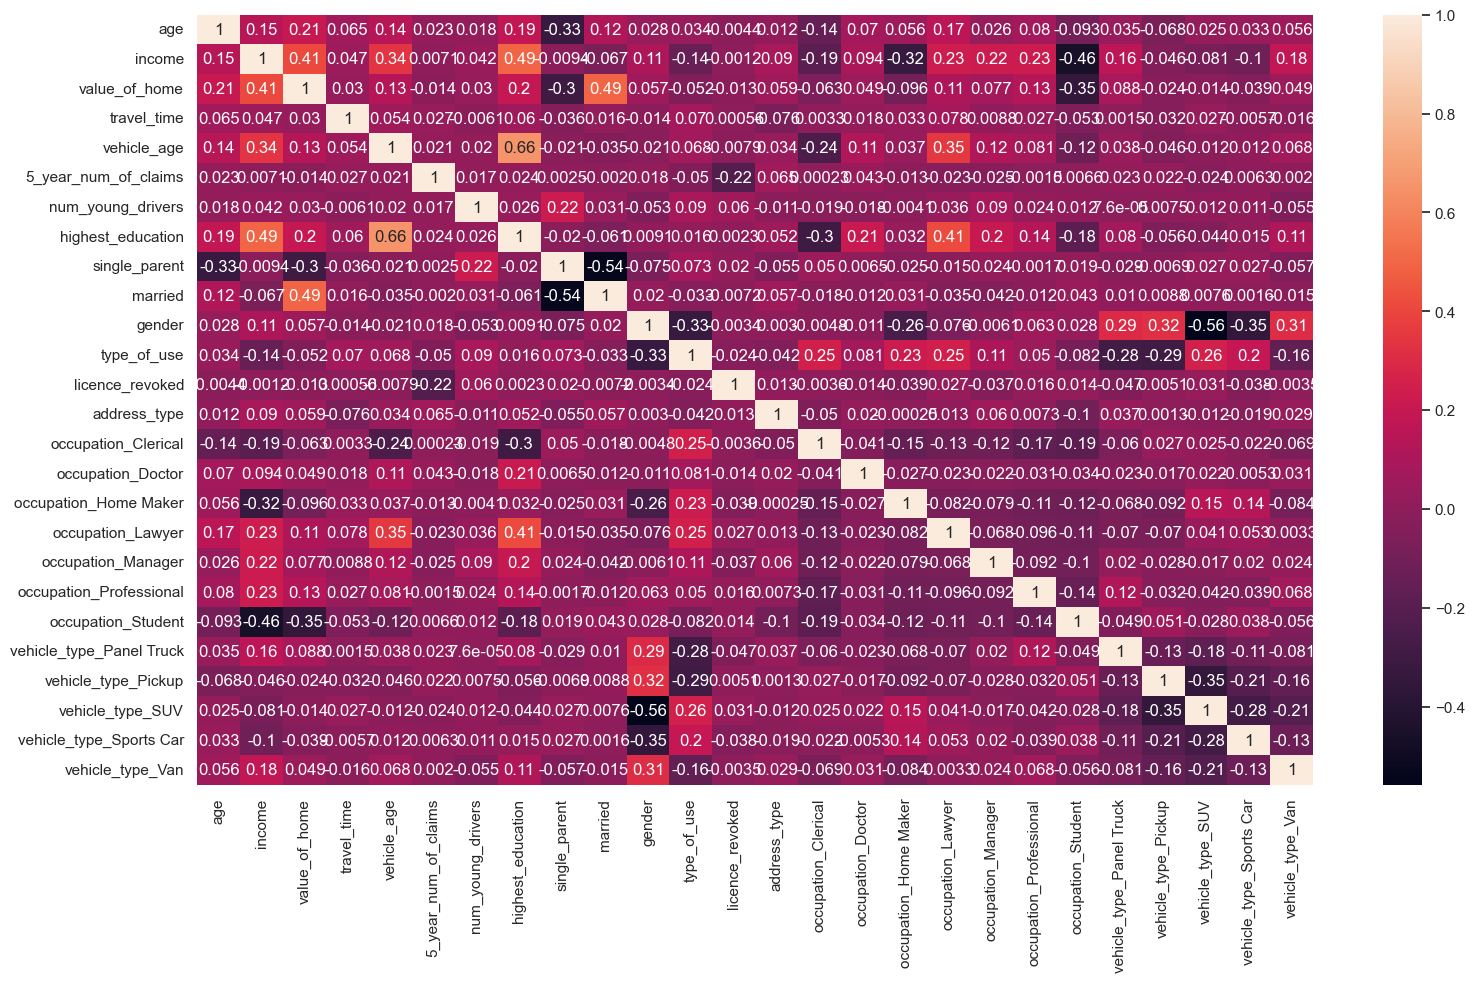

In [65]:
correlation = cleandata.corr()

sns.set_theme()
plt.figure(figsize = (18,10))
sns.heatmap(correlation, cbar = True, annot = True)

In [66]:
#train-test split
# Create clean copy of training data
X = cleandata.copy()
y = insurance_df['new_claim_value']

#scaling
SD = StandardScaler()
SD.fit(X)
X_std = SD.transform(X)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)


In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1729, 26), (433, 26), (1729,), (433,))

In [70]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

reg_results = {}

for reg_name, reg in regs:
    print(f"Evaluating {reg_name}...")
    cv_scores = cross_validate(reg, X_train, y_train, cv=reg_kf, scoring=scoring, return_train_score=False)

    # Negate negative metrics to positive
    mae_scores = -cv_scores['test_MAE']
    mse_scores = -cv_scores['test_MSE']
    rmse_scores = -cv_scores['test_RMSE']
    r2_scores = cv_scores['test_R2']

    reg_results[reg_name] = {
        'MAE Mean': np.mean(mae_scores),
        'MAE Std': np.std(mae_scores),
        'MSE Mean': np.mean(mse_scores),
        'MSE Std': np.std(mse_scores),
        'RMSE Mean': np.mean(rmse_scores),
        'RMSE Std': np.std(rmse_scores),
        'R2 Mean': np.mean(r2_scores),
        'R2 Std': np.std(r2_scores)
    }

# Convert results to DataFrame for better display
reg_cv_scores_df = pd.DataFrame(reg_results).T  # transpose to have models as rows

print(reg_cv_scores_df)


Evaluating Linear Regression...
Evaluating SGD Regressor...
Evaluating Decision Tree Regression...
Evaluating Random Forest...
Evaluating KNN Model...
Evaluating Support Vector Machines (SVM)...
Evaluating XGBRegressor...
                                  MAE Mean     MAE Std      MSE Mean  \
Linear Regression              1642.652942   67.136191  4.122251e+06   
SGD Regressor                  1644.756857   66.799905  4.129453e+06   
Decision Tree Regression       2369.694838   95.180263  8.643728e+06   
Random Forest                  1682.722094   77.158188  4.349281e+06   
KNN Model                      1736.221550  108.392496  4.707848e+06   
Support Vector Machines (SVM)  1617.635745   64.447089  4.022445e+06   
XGBRegressor                   1828.775793   58.025315  5.197789e+06   

                                     MSE Std    RMSE Mean    RMSE Std  \
Linear Regression              289536.530401  2029.061735   71.831244   
SGD Regressor                  284644.283535  2030.8782

In [75]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],           # number of trees
    'max_depth': [None, 10, 20, 30],           # max depth of trees
    'min_samples_split': [2, 5, 10],           # min samples to split node
    'min_samples_leaf': [1, 2, 4],             # min samples per leaf node
    'max_features': ['auto', 'sqrt']            # features considered for split
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',  # Use RMSE as metric
    n_jobs=-1,               # use all CPU cores
    verbose=2
)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Best params and score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
333 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "D:\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validat

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 2023.9151983916813


In [76]:
xgb = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,               # number of parameter settings sampled
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best RMSE: 2010.917931057559


In [71]:

svr = SVR()

param_grid_svr = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

grid_search_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search_svr.fit(X_train, y_train)

print("Best SVR parameters:", grid_search_svr.best_params_)
print("Best SVR RMSE:", -grid_search_svr.best_score_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best SVR parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVR RMSE: 2004.391062307248


In [72]:

dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search_dt.fit(X_train, y_train)

print("Best Decision Tree parameters:", grid_search_dt.best_params_)
print("Best Decision Tree RMSE:", -grid_search_dt.best_score_)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Decision Tree parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Decision Tree RMSE: 2031.4898202628774


D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
400 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
186 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "D:\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validat

In [77]:
best_svr = grid_search_svr.best_estimator_
best_xgb = random_search.best_estimator_
best_rf = grid_search.best_estimator_
best_dt = grid_search_dt.best_estimator_


In [79]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

In [81]:
results = []
results.append(evaluate_model('SVR', best_svr, X_test, y_test))
results.append(evaluate_model('XGBoost', best_xgb, X_test, y_test))
results.append(evaluate_model('Random Forest', best_rf, X_test, y_test))
results.append(evaluate_model('Decision Tree', best_dt, X_test, y_test))

results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)


           Model          MAE           MSE         RMSE        R²
0            SVR  1641.327180  4.135583e+06  2033.613216 -0.001608
1        XGBoost  1647.723567  4.161651e+06  2040.012461 -0.007922
2  Random Forest  1660.514523  4.205624e+06  2050.761692 -0.018571
3  Decision Tree  1678.845805  4.241053e+06  2059.381649 -0.027152


In [82]:
import pickle

svr_model = grid_search.best_estimator_

# Save to pickle file
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(svr_model, f)


In [83]:
import os
print(os.getcwd())


C:\Users\DELL
